# Project 3: 'Image Analysis'
## First Year Project  
### ITU, Spring 2021

This notebook contains all the code developed to explore, wrangle and analyse the raw data sets for our project, 'Image Analysis'.

Contributors:  
- Andy Bao Nguyen (anbn)
- Florian Micliuc (flmi)
- Mattias Wohlert 
- Sofia Elena Terenziani (sote)

Created: 06-04-2021 

Last modified: 22-04-2021

### Imports

In [106]:
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import timeit
import missingno as msno
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image
from collections import Counter
from skimage.color import rgb2hsv
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

### Functions

Sanity check functions

In [2]:
def check_null_values(file, string):
        if file.isnull().values.any():
            print('There are null values in {} dataset'.format(string))
        else:
            print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

In [4]:
def edge_detect(img):
    
    
    test_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    image_unblur = cv2.resize(test_image, (500, 400))
    
    imageB = cv2.GaussianBlur(image_unblur, (5,5), 0) #Bias for if images are considered blurry

    #Laplacian.var() works in such a way that it checks for defined edges, how many clear edges/lines is present
    img_var = cv2.Laplacian(image_unblur, cv2.CV_64F, ksize=11).var()
    img_var_blur = cv2.Laplacian(imageB, cv2.CV_64F, ksize=11).var()

    if img_var < 100000000000:
        print(img_var, "variance value is less than 100 milliard, the image is considered blurry")
    else:
        print(img_var, "variance value is above 100 milliard, image is not considered blurry")

    #Prints the variance value of the blur filter we make in the code, not needed
    #print(img_var_blur, "variance value of an image with gaussian blur filter on")

    
    #cv2.imshow("Original image no blur", image_unblur)
    #cv2.imshow("Blur filter", imageB)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return

Colour analysis functions

In [5]:
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

In [6]:
def RGB2HEX(color):
     return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [7]:
def colour_reader(img,mk):
    im = plt.imread(img)
    #mask is the gray segmentation mask
    mask = plt.imread(mk)
    #putting the color over the mask
    im1 = im.copy()
    im1[mask==0] = 0 #again python dark magic
    #now for better performance we have to crop the image to it's extremities by calling the crop function
    img2 = crop(im1)
    #we have to get the coordinates of every pixel in the image so
    xy_coords = np.flip(np.column_stack(np.where(img2 >= 0)), axis=1)
    #if we print xy_coords they will appear three times because every pixel has three colour coordinates, namely RGB,thus
    #I have to delete the first column(which is 0,1,2) and the duplicates
    a_del = np.delete(xy_coords, 0, 1)
    a_del = a_del[::3][:, [0, 1]] #python dark magic
    #now we get all the rgb colours from every pixel in our picture
    image = Image.fromarray(img2)
    rgb_image = image.convert('RGB')
    rgb1 = [rgb_image.getpixel((int(i[0]),int(i[1]))) for i in a_del]
    #now to reduce it as much as we can we turn it to hexcodes so we don't have tuples of 3 values and we eliminate duplicates
    dd = [RGB2HEX(i) for i in rgb1]
    ss = list(set(dd)) #ye,I know
    #now just a nice thing, to count how many colours appear in our picture, first one is useless since it will always be black
    counter_colours =  Counter(dd)
    #popping the black color
    counter_colours.pop('#000000')
    return counter_colours

In [8]:
    im = plt.imread(img)
    mask = plt.imread(seg)
    im1 = im.copy()
    im1[mask==0] = 0
    new_arr_no_0 = im1[np.where(im1!=0)]
    img2 = crop(im1)
    image_copy = img2.copy()
    non_black_pixels_mask = np.any(img2 != [0, 0, 0], axis=-1)  
    no_black = image_copy[non_black_pixels_mask]
    hsv_image = rgb2hsv(no_black)
    min_max = [np.amax(hsv_image[:,1]) - np.amin(hsv_image[:,1])]
    return min_max

In [9]:
def value(img,seg):
    im = plt.imread(img)
    mask = plt.imread(seg)
    im1 = im.copy()
    im1[mask==0] = 0
    new_arr_no_0 = im1[np.where(im1!=0)]
    img2 = crop(im1)
    image_copy = img2.copy()
    non_black_pixels_mask = np.any(img2 != [0, 0, 0], axis=-1)  
    no_black = image_copy[non_black_pixels_mask]
    hsv_image = rgb2hsv(no_black)
    min_max = [np.amax(hsv_image[:,2]) - np.amin(hsv_image[:,2])]
    return min_max

Asymmetry functions

In [10]:
def asymmetry_level(im): 
    #Read image
    im = plt.imread(im)
    
    #Crop the picture
    #Center of the shape is the center of the image
    #The borders of the shape are the borders of the image
    y_nonzero, x_nonzero = np.nonzero(im)
    im = im[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    
    #Cut the image in halves 
    #Find the point of cutoff
    height, width = im.shape
    width_cutoff = width // 2
    height_cutoff = height // 2
    
    #Cut the image vertically and horizontally in two 
    imVertical1 = im[:, :width_cutoff]
    imVertical2 = im[:, width_cutoff:]
    imHorizontal1 = im[:height_cutoff, :]
    imHorizontal2 = im[height_cutoff:, :]
    
    #Flip image 
    #Interting one of the images both vertically and horizontally   
    indexerVertical = [slice(None)] * imVertical2.ndim
    indexerHorizontal = [slice(None)] * imHorizontal2.ndim
    indexerVertical[1] = slice(None, None, -1)
    indexerHorizontal[0] = slice(None, None, -1) 
    imVertical2 = imVertical2[tuple(indexerVertical)]
    imHorizontal2 = imHorizontal2[tuple(indexerHorizontal)]

    #Cut the biggest image, if the images don't have the same shape 
    #This can happen if the shape of the original shape was an odd number 
    imVertical2 = imVertical2[0:imVertical1.shape[0], 0:imVertical1.shape[1]]
    imHorizontal2 = imHorizontal2[0:imHorizontal1.shape[0], 0:imHorizontal1.shape[1]]

    img_bwxVertical = cv2.bitwise_xor(imVertical1,imVertical2)
    img_bwxHorizontal = cv2.bitwise_xor(imHorizontal1,imHorizontal2)
    
    areaVertical = np.sum(img_bwxVertical == 1)
    areaHorizontal = np.sum(img_bwxHorizontal == 1)
    areaMean = (areaVertical + areaHorizontal) // 2
    
    #The asymmetry level (AS) is calculated as a percentage of the non-zero pixels in the overlapped image over the lesion area 
    return (areaMean / np.sum(im == 1)) *100

Prediction functions

In [11]:
def make_knn_prediction(k,train,classes,test):
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(train,classes.ravel())
    clas_pred = neigh.predict(test)
    return clas_pred

In [12]:
def accuracy_test(k,train,classes,test,classes_test):
    performance = []
    perform1 =[]
    for i in range(1,k):
        a = make_knn_prediction(i,train,classes,test)
        performance.append(a)
        for j in performance:
            b = accuracy_score(classes_test,j)
        perform1.append(b)
    fig, axes = plt.subplots()
    axes.plot(perform1)
    plt.title("Classification Accuracy of KNN for Different Values of k")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Value of k");
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    return np.mean(perform1)

### Loading the data

Data loading description pending

In [13]:
image_folder = '../data/raw/example_image/'
segmentation_folder = '../data/raw/example_segmentation/'

extra_image_folder = '../data/raw/extra_keratosis'
extra_segmentation_folder = '../data/raw/extra_segmentation'


extra_ground_truth = '../data/raw/ISIC-2017_Training_Part3_GroundTruth.csv'
ground_truth = '../data/raw/example_ground_truth.csv'
features = '../data/features/features.csv'

In [14]:
image_files = os.listdir(image_folder)
segmentation_files = os.listdir(segmentation_folder)

extra_image_files = os.listdir(extra_image_folder)
extra_segmentation_files = os.listdir(extra_segmentation_folder)

extra_gt = pd.read_csv(extra_ground_truth)
ground_truth = pd.read_csv(ground_truth)
features = pd.read_csv(features)

## Task 0 - Data checking and filtering

### CSV files sanity checks

In [15]:
check_null_values(ground_truth,'ground_truth')
check_null_values(features,'features')
check_null_values(extra_gt,'extra_ground_truth')

There are no null values in ground_truth dataset
There are no null values in features dataset
There are no null values in extra_ground_truth dataset


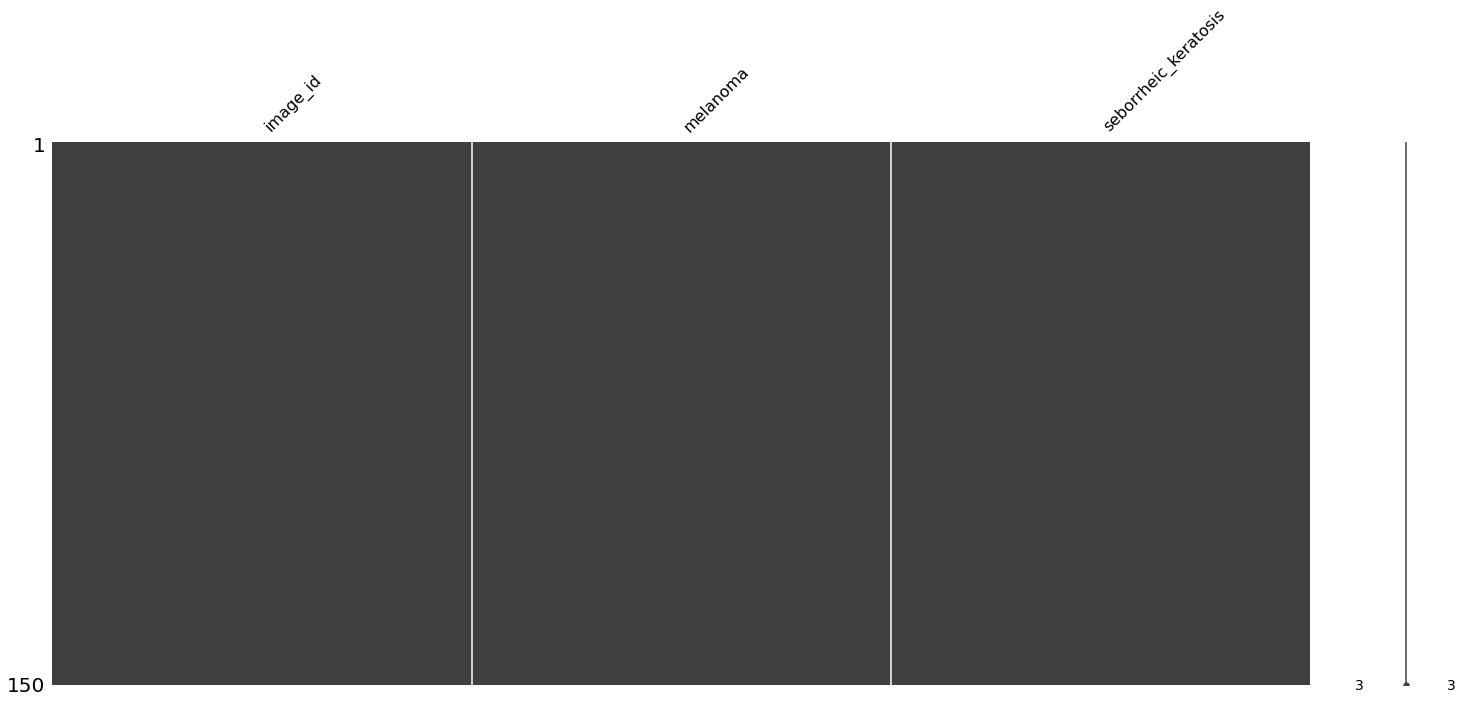

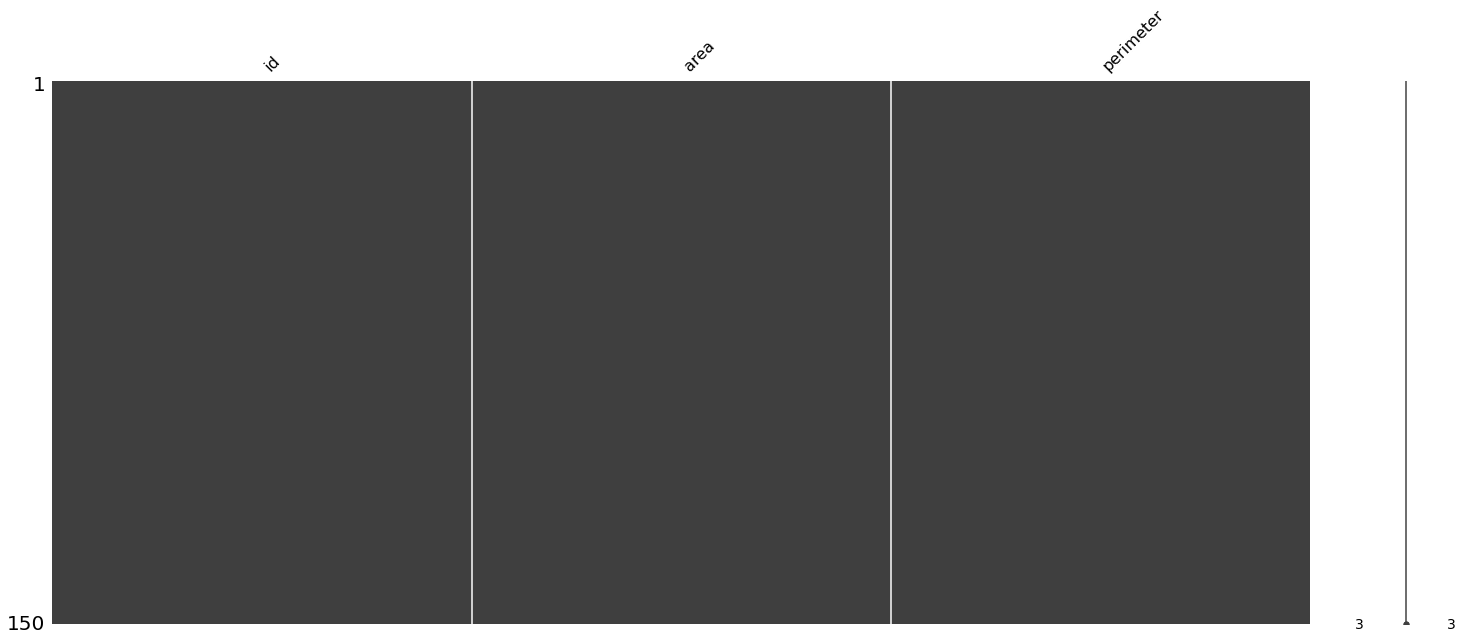

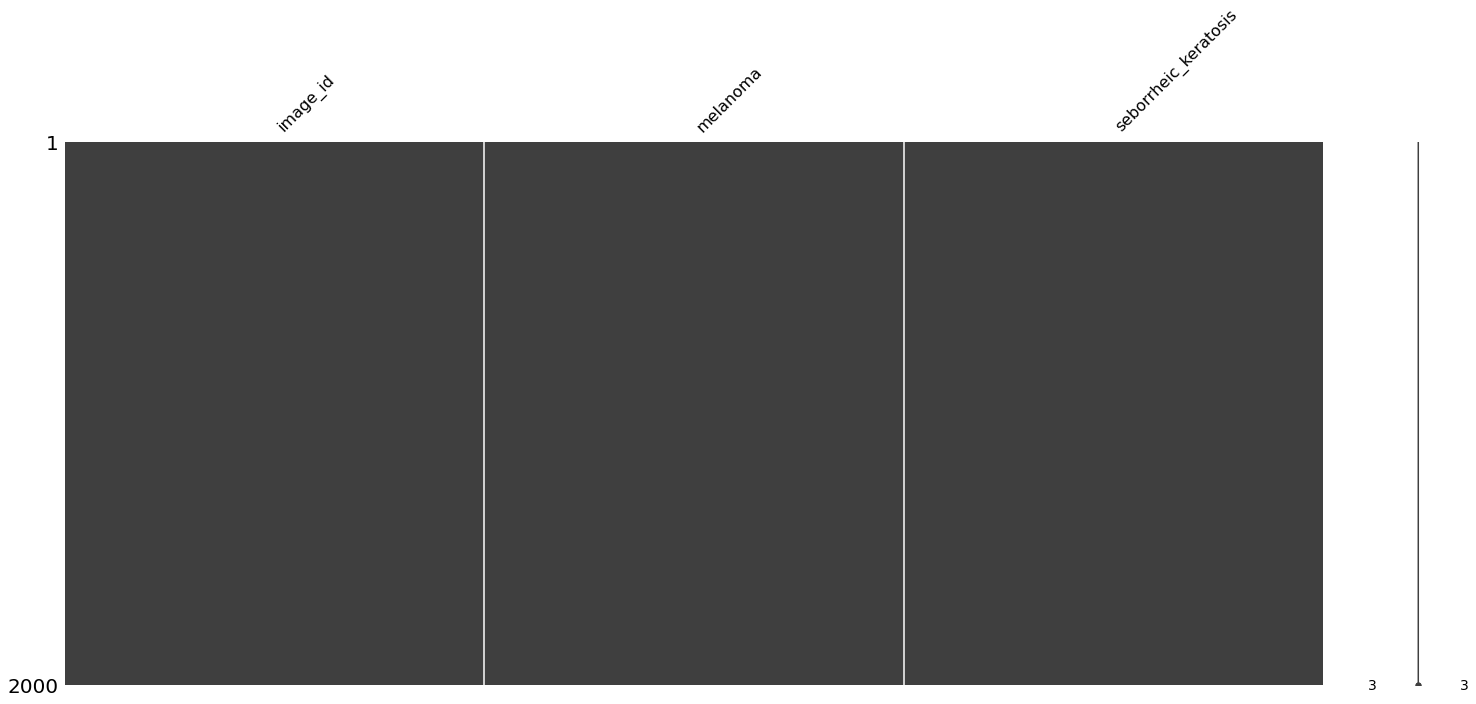

In [16]:
dataset_checker_values(ground_truth,-1)
dataset_checker_values(features,-1)
dataset_checker_values(extra_gt,-1)

There are no gaps in the plots, thus the value -1 (missing data) does not occur in the dataset

In [17]:
if True in list(ground_truth.duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


In [18]:
if True in list(features.duplicated()):
    print("Duplicate rows")
else:
    print("No duplicate rows")

No duplicate rows


In [19]:
if True in list(extra_gt.duplicated()):
    print('Duplicate rows')
else:
    print('No duplicate rows')

No duplicate rows


### Data Manipulation

In [20]:
ground_truth = ground_truth.set_index('image_id')
features = features.set_index('id')
extra_gt = extra_gt.set_index('image_id')

In [21]:
color_images_paths = []
segmentation = []

# getting the image_paths
for i in image_files[1:]:
    image_path= os.path.join(image_folder,i)
    if not i.endswith('superpixels.png'):
        color_images_paths.append(image_path)
for i in segmentation_files:
    image_path1 = os.path.join(segmentation_folder,i)
    segmentation.append(image_path1)

both_images = list(zip(color_images_paths,segmentation))

#splitting the images
keratosis_images = ground_truth.index[ground_truth['seborrheic_keratosis'] == 1.0].tolist()
melanoma_images = ground_truth.index[ground_truth['melanoma'] == 1.0].tolist()
healthy_images = ground_truth[(ground_truth['seborrheic_keratosis'] == 0.0) & (ground_truth['melanoma'] == 0.0)]
#print(healthy_images.index.tolist) - to get only the healthy images in a list hence the healthy_images is a df

keratosis = [os.path.join(image_folder,i + '.jpg') for i in keratosis_images] #positive keratosis colour_images path
melanoma = [os.path.join(image_folder,i + '.jpg') for i in melanoma_images] #positive melanoma colour_images path
healthy = [os.path.join(image_folder,i + '.jpg') for i in healthy_images.index.tolist()] #healthy colour_images path

k_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in keratosis_images] #positive keratosis segmentation path
m_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in melanoma_images] #positive melanoma segmentation path
h_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in healthy_images.index.tolist()]#healthy segmentation path"

In [22]:
final_keratosis = list(zip(keratosis,k_segmentation))
final_melanoma = list(zip(melanoma,m_segmentation))
final_healthy = list(zip(healthy,h_segmentation))

### Extra Data - provided from ISIC 2017 challenge

In [23]:
extra_keratosis = [os.path.join(extra_image_folder,i) for i in extra_image_files]
extra_segmentation = [os.path.join(extra_segmentation_folder,i) for i in extra_segmentation_files ]
final_extra = list(zip(extra_keratosis,extra_segmentation))

In [24]:
Keratosis_all = final_keratosis + final_extra

In [25]:
segm_k_all = k_segmentation + extra_segmentation

### Image check

Bluriness detection for every image in the extra_keratosis dataset (200 images)

In [126]:
#check = [edge_detect(i) for i in extra_keratosis]

In [ ]:
#check = [edge_detect(i) for i in keratosis]

In [131]:
shape_list = []
for i in extra_keratosis:
    a = plt.imread(i)
    shape_list.append(a.shape)

In [141]:
shape_list_2 = []
for i in keratosis:
    b = plt.imread(i)
    shape_list_2.append(b.shape)

In [147]:
shape_df_extra = pd.DataFrame(shape_list,columns = ['Height','Width','Channels'])
shape_df = pd.DataFrame(shape_list_2,columns = ['Height','Width','Channels'])
#the (,,3) represent wether or not it is a coloured picture

The bluriness detection and the graphic resolution both are powerful tools into disqualifying images. The bluriness detection is something which we still need to investigate if it is a reliable tool to use for disqualification. On the other hand, graphic resolution could tell us about how visible are the small details (the bigger the resolution, the more pixels there are) and it is very reliable to disqualify images for that.  

Ultimately, our group decided to not disqualify any images from the extra dataset or the original dataset due to the reasoning that after careful investigation we decided that all images fit our requested parameters, thus no extra filtering was needed.

## Task 1 - Feature analysis

### 1.1 Colour Analysis - Step by step example of the colour_reader function

Reading the coloured and the segmentation files

In [28]:
im = plt.imread(keratosis[1])
mask = plt.imread(k_segmentation[1])

Basic knowledge about the lession such as area and perimeter (not absolutely necessary for colour analysis)

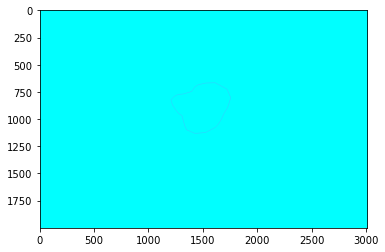

In [29]:
area = np.sum(mask)
struct_el = morphology.disk(1)
mask_eroded = morphology.binary_erosion(mask, struct_el)
image_perimeter = mask - mask_eroded
perimeter = np.sum(image_perimeter)
plt.imshow(image_perimeter,cmap = 'cool') # really small but visible with cool cmap
#print(' The area is -> ',area,'\\n','The perimeter is -> ',perimeter)

Taking the lession and displaying it over the segmentation

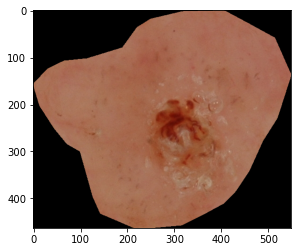

In [30]:
im1 = im.copy()
im1[mask==0] = 0
new_arr_no_0 = im1[np.where(im1!=0)]
#cropping the image for better performance
im1 = crop(im1)
plt.imshow(im1) #not best crop but manageable

Getting every pixel's coordinates

In [31]:
xy_coords = np.flip(np.column_stack(np.where(im1 >= 0)), axis=1)
a_del = np.delete(xy_coords, 0, 1)
a_del = a_del[::3][:, [0, 1]] #python dark magic and true coordinates

Getting every pixel's RGB values and converting them to HEX codes

In [32]:
image = Image.fromarray(im1)
rgb_image = image.convert('RGB')
rgb1 = [rgb_image.getpixel((int(i[0]),int(i[1]))) for i in a_del] #getting the RGB value for every pixel in the lession
hex_codes = [RGB2HEX(i) for i in rgb1] #converting all to hex
counted_colours = Counter(hex_codes) #counting them
counted_colours.pop('#000000') #popping the blackest black colour
print(len(rgb1)) #3,379,770 

253724


In [33]:
#print(counted_colours)

The conversion of the RGB values to hex codes is due to the fact RGB values come in tuples of three (R,G,B), therefore, for a better performance we turn them to HEX codes ( which are basically #RGB values ) and then we count their appearance

In [34]:
# really long running time, ~ 1h
final_k = [colour_reader(i[0],i[1]) for i in Keratosis_all]
final_h = [colour_reader(i[0],i[1]) for i in final_healthy]

In [35]:
k_len = [len(i) for i in final_k]
h_len = [len(i) for i in final_h]

Preparing k_len and h_len for the prediction algorithm

k_len - is the number of colours found in every picture (in every pixel of that picture) for the keratosis dataset  
h_len - is the number of colours found in every picture (in every pixel of that picture) for the healthy dataset

### 1.2 Colour Analysis - Step by step example explaining the hsv function

In [36]:
image_copy = im1.copy()
non_black_pixels_mask = np.any(im1 != [0, 0, 0], axis=-1)  

Copying the first image and then creating a mask without the black borders

In [37]:
hsv_pic = rgb2hsv(image_copy[non_black_pixels_mask])
maximum = np.max(hsv_pic[:,1])
minimum = np.min(hsv_pic[:,1])

Converting the image from RGB values to HSV values to get the saturation and getting the difference between brightest and darkest spot

In [55]:
k_hsv = [hsv(i[0],i[1]) for i in Keratosis_all]
h_hsv = [hsv(i[0],i[1]) for i in final_healthy]

Preparing k_hsv and h_hsv for the predicition algorithm

k_hsv - is the difference between the brightest and darkest points from every picture in the keratosis dataset  
h_hsv - is the difference between the brightest and darkest points from every picture in the healthy dataset

### 1.3 Symmetry analysis - Step by step example explaining the asymmetry level function

In [39]:
im_sym = plt.imread(k_segmentation[1])
y_nonzero, x_nonzero = np.nonzero(im_sym)
im_sym = im_sym[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

Crop the picture  
Center of the shape is the center of the image  
The borders of the shape are the borders of the image

In [40]:
height, width = im_sym.shape
width_cutoff = width // 2
height_cutoff = height // 2

Cut the image in halves   
Find the point of cutoff

In [41]:
imVertical1 = im_sym[:, :width_cutoff]
imVertical2 = im_sym[:, width_cutoff:]
imHorizontal1 = im_sym[:height_cutoff, :]
imHorizontal2 = im_sym[height_cutoff:, :]

Cut the image vertically and horizontally in two 

In [42]:
indexerVertical = [slice(None)] * imVertical2.ndim
indexerHorizontal = [slice(None)] * imHorizontal2.ndim
indexerVertical[1] = slice(None, None, -1)
indexerHorizontal[0] = slice(None, None, -1) 
imVertical2 = imVertical2[tuple(indexerVertical)]
imHorizontal2 = imHorizontal2[tuple(indexerHorizontal)]

Flip image  
Interting one of the images both vertically and horizontally  

In [43]:
imVertical2 = imVertical2[0:imVertical1.shape[0], 0:imVertical1.shape[1]]
imHorizontal2 = imHorizontal2[0:imHorizontal1.shape[0], 0:imHorizontal1.shape[1]]

Cut the biggest image, if the images don't have the same shape   
This can happen if the shape of the original shape was an odd number 

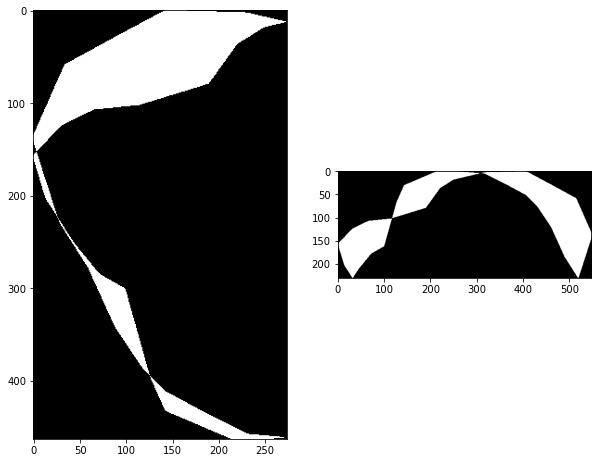

In [44]:
img_bwxVertical = cv2.bitwise_xor(imVertical1,imVertical2)
img_bwxHorizontal = cv2.bitwise_xor(imHorizontal1,imHorizontal2)
fig, axes = plt.subplots(1, 2, figsize =(10,10))
axes[0].imshow(img_bwxVertical, cmap='gray')
axes[1].imshow(img_bwxHorizontal, cmap='gray')

In [45]:
areaVertical = np.sum(img_bwxVertical == 1)
areaHorizontal = np.sum(img_bwxHorizontal == 1)
areaMean = (areaVertical + areaHorizontal) // 2

In [46]:
print(areaMean / np.sum(im_sym == 1) *100)

15.263028916843652


The asymmetry level (AS) is calculated as a percentage of the non-zero pixels in the overlapped image over the lesion area 

In [47]:
k_sym = [asymmetry_level(i) for i in segm_k_all]
h_sym = [asymmetry_level(i) for i in h_segmentation]

Preparing k_sym and h_sym for the prediction algorithm

k_sym - is the asymmetry level of every segmentation picture in the keratosis segmentation dataset  
h_sym - is the asymmetry level of every segmentation picture in the healthy segmentation dataset

## Task 2 - Diagnosis prediction

In [48]:
clas_k = np.array([1 for i in range(len(Keratosis_all))])
clas_h = np.array([0 for i in range(len(healthy))])
clas = np.array([y for x in [clas_k, clas_h] for y in x])

### 2.1 - Color variation

In [49]:
feed = np.array(k_len + h_len)

In [50]:
feed_train,feed_test,clas_train,clas_test = train_test_split(feed,clas,test_size = 0.6,random_state = 4)

In [51]:
feed_train= feed_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed_test = feed_test.reshape(-1, 1)

In [52]:
print(make_knn_prediction(7,feed_train,clas_train,feed_test))
print(clas_test)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7349439775910361

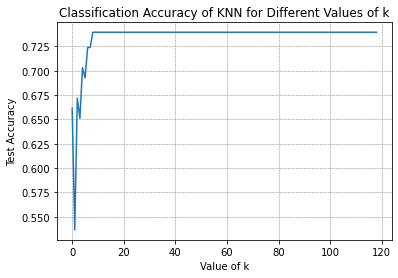

In [53]:
accuracy_test(120,feed_train,clas_train,feed_test,clas_test)

### 2.2 Saturation

In [56]:
feed2 = np.array([y for x in [k_hsv, h_hsv] for y in x])

In [57]:
feed2_train,feed2_test,clas_train,clas_test = train_test_split(feed2,clas,test_size = 0.6,random_state = 4)

In [58]:
feed2_train= feed2_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed2_test = feed2_test.reshape(-1, 1)

In [113]:
print(make_knn_prediction(7,feed2_train,clas_train,feed2_test))
print(clas_test)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7416841736694676

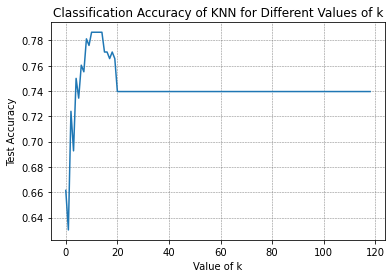

In [114]:
accuracy_test(120,feed2_train,clas_train,feed2_test,clas_test)

### 2.3 Asymmetry

In [61]:
feed3 = np.array([y for x in [k_sym, h_sym] for y in x])

In [62]:
feed3_train,feed3_test,clas_train,clas_test = train_test_split(feed3,clas,test_size = 0.6,random_state = 4)

In [63]:
feed3_train= feed3_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed3_test = feed3_test.reshape(-1, 1)

In [64]:
print(make_knn_prediction(7,feed3_train,clas_train,feed3_test))
print(clas_test)

[1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7345500700280109

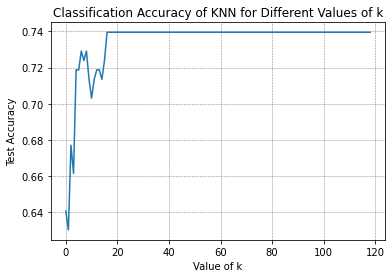

In [65]:
accuracy_test(120,feed3_train,clas_train,feed3_test,clas_test)

## Task 3 - Open question

Our open question is in regards with the saturation ( which in our case measures the difference between the most saturated and the least saturated colours in the lession thus showing us the saturation variation) and the lightness value ( which in our case measures the diffrence between the brightest and the darkest colours in the lession thus showing us the lightness variation ). Therefore the question is which one would be more fitted to be a good feature to predict the diagnosis of a skin lession.

In [66]:
k_value = [value(i[0],i[1]) for i in Keratosis_all]
h_value = [value(i[0],i[1]) for i in final_healthy]

We take the difference between the brightest and darkest colour in all 242 keratosis pictures and the 78 healthy pictures and then feed them to the KNN classifier

In [67]:
feed4 = np.array([y for x in [k_value,h_value] for y in x])

In [68]:
feed4_train,feed4_test,clas_train,clas_test = train_test_split(feed4,clas,test_size = 0.6,random_state = 4)

In [69]:
feed4_train= feed4_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed4_test = feed4_test.reshape(-1, 1)

In [109]:
print(make_knn_prediction(7,feed4_train,clas_train,feed4_test))
print(clas_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7316176470588233

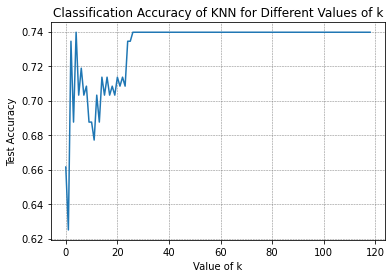

In [110]:
accuracy_test(120,feed4_train,clas_train,feed4_test,clas_test)

Then we comput the accuracy score for our model

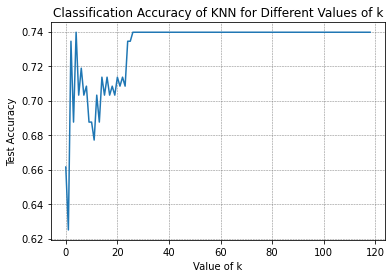

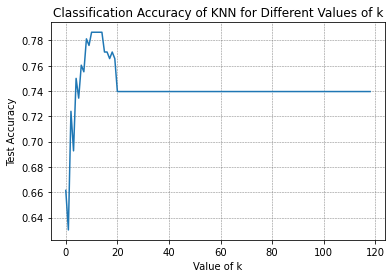

In [120]:
accuracy_test(120,feed4_train,clas_train,feed4_test,clas_test)
accuracy_test(120,feed2_train,clas_train,feed2_test,clas_test);

We compare the accuracy scores of both models and both seem to stabilize at ~74% accuracy.

In [122]:
average_precision_value = average_precision_score(clas_test,feed4_test)
average_precision_saturation = average_precision_score(clas_test,feed2_test)

Then we compute average_precision value for both models

In [124]:
print('The precision for the lightness value of the colour is',average_precision_value)
print('The precision for the difference of the saturation of the colour',average_precision_saturation)

The precision for the lightness value of the colour is 0.7262584442720654
The precision for the difference of the saturation of the colour 0.6649246652534513


From this analysis we can conclude (if there are no flaws in our implementation) that the lightness variation is slighty more precise than the saturation variation. Though this conclusion raises other questions:  
- Is the ~0.06 difference significant? 
- Can it affect the results of the model in any way?